[View in Colaboratory](https://colab.research.google.com/github/EoinRaff/AIP_Miniproject/blob/master/AIP_Miniproject.ipynb)

# Mount Google Drive and Enable Collaboratory

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp7w8zblcw/pubring.gpg' created
gpg: /tmp/tmp7w8zblcw/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [3]:
import os
os.chdir("drive/AIP_Miniproject")
!dir


AIP_Miniproject.ipynb			    nature.jpg
block.jpg				    newyork.jpg
bridgeDay.jpg				    output
bridgeNight.jpg				    picasso.jpg
content					    README.md
content.jpg				    Results.odt
dali.jpg				    scream.jpg
drive					    selfie.jpg
eoin.jpg				    selfie_van_gogh.png
eoin_wave_forest_c0025_s5_i1.png	    sketch.jpg
eoin_wave_forest_c0025_s5_i5.png	    starry_night.jpg
eoin_wave_forest_c025_s5_i1.png		    styles
eoin_wave_forest_c035_s5_i1.png		    thomas.jpg
eoin_wave_forest_c035_s5_tv05_i1.png	    vanBlock2.png
eoin_wave_forest_c05_s5_i1.png		    vanBlock.png
eoin_wave_vangogh_c035_s5_tv05_i1_b4c2.png  van_blough2.png
eoin_wave_vangogh_c035_s5_tv05_i1.png	    van_blough.png
eoin_wave_vangogh_c5_s5_tv05_i1_b4c2.png    vanGogh.ipynb
eoin_wave_vangogh_c5_s5_tv1_i1_b4c2.png     van_gough\ (bae32967).jpg
forest.jpg				    vanGoughit1.png
gothic.jpg				    vanGoughit2.png
main.ipynb				    vanGoughit3.png
marilyn\ (97444732).jpg			    van_gough.jpg
marilyn.jpg				    wave.jpg


# Choose Style and Content Images
Images are resized to be all of the same dimensions. In this case, a size of 512 x 512 is chosen.


In [4]:
from __future__ import print_function
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


Using TensorFlow backend.


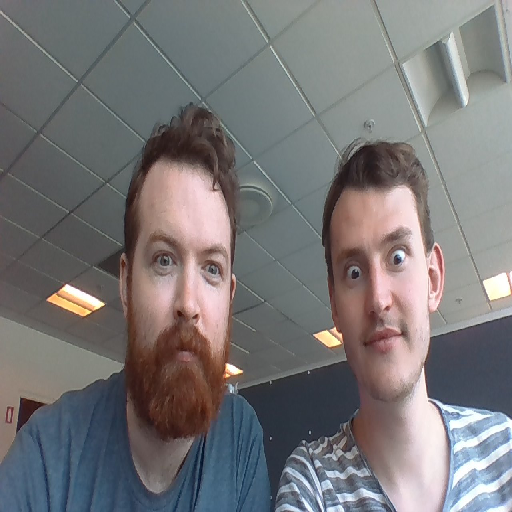

In [233]:
height = 512
width = 512

content_img_path = 'selfie.jpg'
content_img = Image.open(content_img_path)
content_img = content_img.resize((height, width))
content_img

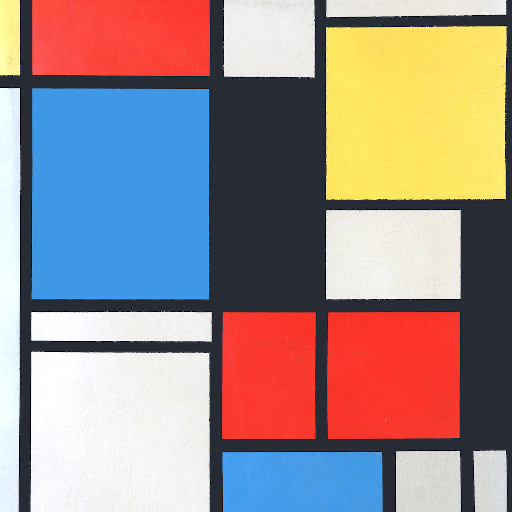

In [234]:
style_img_path = 'block.jpg'
style_img = Image.open(style_img_path)
style_img = style_img.resize((height, width))
style_img


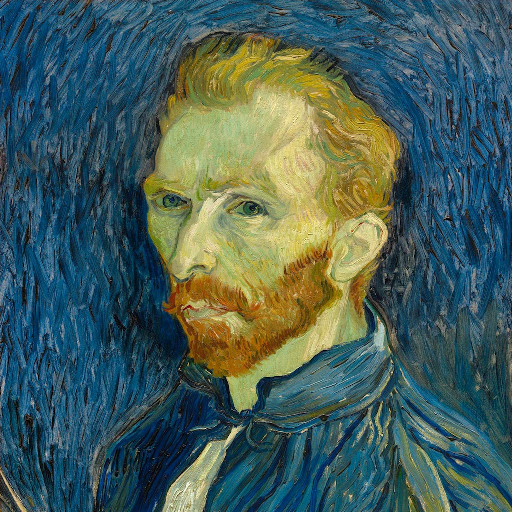

In [235]:
style_img_path_2 = 'van_gough.jpg'
style_img_2 = Image.open(style_img_path_2)
style_img_2 = style_img_2.resize((height, width))
style_img_2


# Pre-Process Images
This section converts the images to NumPy arrays. It then subtracts the mean RBG values from each color channel, and re-arranges the arrays to BGR.

A tensor is then prepared by concatenating the arrays for the style and content images, and a placerholder for the combined image.

In [236]:
content_array = np.asarray(content_img, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_img, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

style_array_2 = np.asarray(style_img_2, dtype='float32')
style_array_2 = np.expand_dims(style_array_2, axis=0)
print(style_array_2.shape)



(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
content_array[:,:,:,0] -= 103.939
content_array[:,:,:,1] -= 116.779
content_array[:,:,:,2] -= 123.68
content_array = content_array[:,:,:,::-1]

style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
style_array = style_array[:,:,:,::-1]

style_array_2[:,:,:,0] -= 103.939
style_array_2[:,:,:,1] -= 116.779
style_array_2[:,:,:,2] -= 123.68
style_array_2 = style_array_2[:,:,:,::-1]

In [0]:
content_img = backend.variable(content_array)
style_img = backend.variable(style_array)
style_img_2 = backend.variable(style_array_2)
combination_img = backend.placeholder((1, height, width, 3))

In [0]:
input_tensor = backend.concatenate([content_img,
                                      style_img,
                                      style_img_2,
                                      combination_img], axis=0)

# Use VGG16 model to define loss function


In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top = False)


In [241]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_8/Relu:0' shape=(4, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_8/Relu:0' shape=(4, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_8/MaxPool:0' shape=(4, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_8/Relu:0' shape=(4, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_8/Relu:0' shape=(4, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_8/MaxPool:0' shape=(4, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_8/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_8/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_8/Relu:0' shape=(4, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_8/MaxPool:0' shape=(4, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_8/Relu:0' shape=(4, 64, 64, 51

Layers are printed for reference in following sections


# Define Image Weights
These weights are arbitrarily chosen based on experiments, and determine the aesthetic of the output image


In [0]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
loss = backend.variable(0.)

#Content Loss

The content loss is the scaled squared Euclidian distance between feature representations of the content and combination images.

Images created using earlier layers, e.g.  ```block2_conv2``` will retain most of the structure of the content image. Using later layers, e.g. ```block4_conv2``` will see the content more distorted.



In [0]:
def content_loss(content, combination):
  return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2'] # To do: Try different Layers here!
content_img_features = layer_features[0, :, :, :]
combination_features = layer_features[3, :, :, :]

loss += content_weight * content_loss(content_img_features, combination_features)


#Style Loss

Style loss is firstly defined by a *gram matrix*, whichh determines which features often occur together. 

This will enable the network to only catch information about the style, while ignoring the specific arrangment of objects in the image.

In [0]:
def gram_matrix(x):
  features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
  gram = backend.dot(features, backend.transpose(features))
  return gram


The style loss is then calculated as the *Frobenius Norm* (a measure of magnitude) of the difference between the gram matrices of the style and 
combination images. 

The ```feature_layers``` below are suggested by [Johnson et. al. (2016)](https://arxiv.org/abs/1603.08155). Different layers will produce vastly different results. It is recommended to use at least one layer from each block.

In [0]:
def style_loss(style1, style2, combination):
  s1 = gram_matrix(style1)
  s2 = gram_matrix(style2)
  c = gram_matrix(combination)
  channels = 3
  size = height * width
  return backend.sum(backend.square(s1 - c)+backend.square(s2 - c)) / (4. * (channels ** 2)*(size ** 2))

def style_loss_1(style, combination):
  s = gram_matrix(style)
  c = gram_matrix(combination)
  channels = 3
  size = height * width
  return backend.sum(backend.square(s - c)) / (4. * (channels ** 2)*(size ** 2))


feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
#johnson et al features layers

#gatys et al. feature layers

for layer_name in feature_layers:
  layer_features = layers[layer_name]
  style_features_1 = layer_features[1, :, :, :]  
  style_features_2 = layer_features[2, :, :, :]
  combination_features = layer_features[3, :, :, :]
  sl = style_loss(style_features_1, style_features_2, combination_features)
  sl_1 = style_loss_1(style_features_1, combination_features)
  sl_2 = style_loss_1(style_features_2, combination_features)
  loss += (style_weight / len(feature_layers)) * sl
#  loss += (style_weight / len(feature_layers)) * sl_1
#  loss += (style_weight / len(feature_layers)) * sl_2


  

#Total Variation Loss

Total variation loss reduces the noisiness of the output image.

In [0]:
def total_variation_loss(x):
  a = backend.square(x[:, :height-1, :width-1, :]-x[:, 1:, :width-1, :])
  b = backend.square(x[:, :height-1, :width-1, :]-x[:, :height-1, 1:, :])
  return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_img)

# Define Function for calculating gradients and minimizing loss.
The ```Evaluator``` class

In [0]:
grads = backend.gradients(loss, combination_img)

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_img], outputs)

def eval_loss_and_grads(x):
  x = x.reshape((1, height, width, 3))
  outs = f_outputs([x])
  loss_value = outs[0]
  grad_values = outs[1].flatten().astype('float64')
  return loss_value, grad_values

class Evaluator(object):
  
  def __init__(self):
        self.loss_value = None
        self.grads_values = None

  def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

  def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
evaluator = Evaluator()

# Perform Style Transfer
The loss will decrease over iterations, producing images which "blend" the style and content better, within the contstraints of the chosen weights and feature layers. 

Changing the number of iterations can produce interesting results, particularly when combined with changes to the weights defined earlier.

In [250]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
  
  
  print('Current loss value:', min_val)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))
  

Start of iteration 0
Current loss value: 566812930000.0
Iteration 0 completed in 26s
Start of iteration 1
Current loss value: 380676200000.0
Iteration 1 completed in 24s
Start of iteration 2
Current loss value: 344466880000.0
Iteration 2 completed in 24s
Start of iteration 3
Current loss value: 334371980000.0
Iteration 3 completed in 24s
Start of iteration 4
Current loss value: 329490760000.0
Iteration 4 completed in 24s
Start of iteration 5
Current loss value: 325674570000.0
Iteration 5 completed in 24s
Start of iteration 6
Current loss value: 322943680000.0
Iteration 6 completed in 24s
Start of iteration 7
Current loss value: 320747100000.0
Iteration 7 completed in 24s
Start of iteration 8
Current loss value: 318925470000.0
Iteration 8 completed in 24s
Start of iteration 9
Current loss value: 317595780000.0
Iteration 9 completed in 24s


In [0]:
x = x.reshape((height, width, 3))
x = x[:,:,::-1]
x[:,:,0] += 103.939
x[:,:,1] += 116.779
x[:,:,2] += 123.68

x = np.clip(x, 0, 255).astype('uint8')
im = Image.fromarray(x)


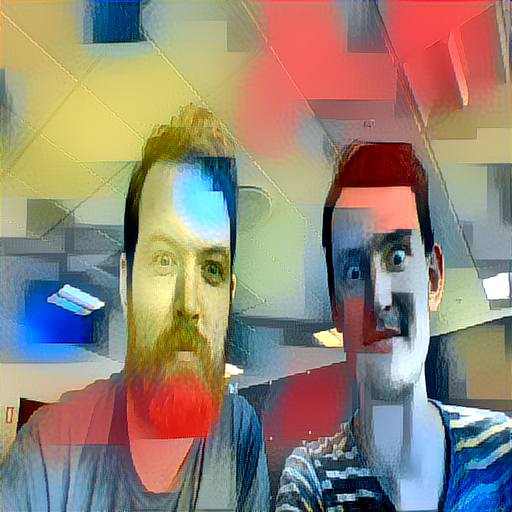

In [252]:
im